# Tutorial 5

## Load required packages

In [1]:
import os
import copy
import re
import random
import mygene
import pandas as pd
import numpy as np
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd = os.getcwd()

In [3]:
# Check this is set correctly to '/home/<SUNetID>/BIOC281/Classes/5' on FarmShare
# On Sherlock it should be /home/groups/<Group_Name>/BIOC281/Classes/5/
pwd

'/home/ktrav/BIOC281/Classes/5'

## Data ingest

In [4]:
# Read in the SmartSeq2 data and sort the cells alphanumerically
adata = sc.read_csv(filename=os.path.join(pwd, 'krasnow_hlca_facs_counts.csv')).T
adata = adata[adata.obs_names.sort_values()]

# Read in the SmartSeq2 metadata and sort the cells alphanumerically
tmp = pd.read_csv(filepath_or_buffer=os.path.join(pwd, 'krasnow_hlca_facs_metadata.csv'), index_col=0).sort_index()
adata.obs = tmp.copy()

# Stash counts in a new layer
adata.layers['counts'] = adata.X.copy()

# Normalize counts to counts per million, log them, and store the ln(counts per million + 1) in adata.raw.X
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata

# Select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.5)

# Center and scale log normalized expression values and run PCA
sc.pp.scale(adata, max_value=10)

# Write the SmartSeq2 object to an h5ad object
adata.write(os.path.join(pwd, 'krasnow_hlca_facs_normalized.h5ad'))

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig.ident' as categorical
... storing 'plate.barcode' as categorical
... storing 'organism' as categorical
... storing 'tissue' as categorical
... storing 'region' as categorical
... storing 'label' as categorical
... storing 'sorter' as categorical
... storing 'sort.location' as categorical
... storing 'sample' as categorical
... storing 'location' as categorical
... storing 'gating' as categorical
... storing 'free_annotation' as

In [5]:
# Read in the h5ad object, this seems to halve the memory usage
adata = sc.read_h5ad(os.path.join(pwd, 'krasnow_hlca_facs_normalized.h5ad'))

## Identify differentially expressed genes

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   
    # Use the groupby() command from the pandas library to show 
    # the number of cells in each predicted type
    print(adata.obs.groupby(["free_annotation"]).size().reset_index(name="Number"))

                         free_annotation  Number
0                 Adventitial Fibroblast     158
1                   Airway Smooth Muscle     346
2             Alveolar Epithelial Type 1     421
3             Alveolar Epithelial Type 2     760
4                    Alveolar Fibroblast     360
5                                 Artery      92
6                                      B     129
7                                  Basal     240
8                        Basophil/Mast 1      46
9                     Bronchial Vessel 1     106
10                CD4+ Memory/Effector T     126
11                          CD4+ Naive T     131
12                CD8+ Memory/Effector T      59
13                          CD8+ Naive T     378
14                             Capillary     872
15                    Capillary Aerocyte     622
16              Capillary Intermediate 1      88
17                              Ciliated     551
18                    Classical Monocyte     106
19                  

In [7]:
# The number of cells in each type vary in this dataset over 3 orders of magnitude
# If you performed differential gene expression analysis as-is scanpy would compare each group of cells
# versus all other cells, which is currently dominated by NK, Club, and Capillary cells, among others.
#
# To more accurately identify genes specific to each group, it is important to downsample groups
# with large numbers of cells. It is also important to think about what comparison would yeild
# cell type specific markers. Cell types are most similar to those in their compartments, so if 
# you compare them against all other cells, you tend to find their compartment markers. 
# If, instead, you compare them to cells within their compartment, you often find specific marker genes.
#
# Both decisions carry risks, like the downsampled cells not being representative or finding markers that are
# also found in other comparements. But the benefits usually outweigh the downsides
# Generally, there's no one "correct" way to calculate differential gene expression and, as always,
# your research question should guide you

# Create a copy of the adata object to downsample groups with large numbers of cells
adata_ds = copy.deepcopy(adata)

In [8]:
# Python lists are collections of objects (usually strings and numbers)
# that can be referenced by their position and appended to
# such as the my_list = [1, 'two', 3], where my_list[0] would return 1
# and my_list[:1] would return [1, 'two']
# Lists can be combined with the "+" operator like this:
# my_list + ['four', 5, 6] would return [1, 'two', 3, 'four', 5, 6]
#
# Create an empty list of cells to use in the downsampled adata object
cells = []

# Loop through each cell type, called with the cat.categories function in pandas
for i in adata.obs.free_annotation.cat.categories:
    
    # Get a list of cells whose free_annotation matches the current cell type
    tmp = adata[adata.obs.free_annotation == i].obs_names.to_list()
    
    # If it has more than 100 cells, randomly sample 100 of them using the sample()
    # function in the random library
    if len(tmp) > 100:
        cells = cells + random.sample(tmp, k=100)
    
    # If not, take all of them
    else:
        cells = cells + tmp

# Subset adata_ds to the chosen cells
adata_ds = adata_ds[cells]
adata_ds

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 2932 × 58683
    obs: 'nGene', 'nReads', 'orig.ident', 'plate.barcode', 'cell.id', 'organism', 'tissue', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'patient', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of input reads', 'Uniquely mapped reads number', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT/AG', 'Number of splices: GC/AG', 'Number of splices: AT/AC', 'Number of splices: Non-canonical', 'Number of reads mapped to multiple loci', 'Number of reads mapped to too many loci', 'Number of chimeric reads', 'Mapping speed, Million of reads per hour', 'Average input read length', 'Uniquely mapped reads %', 'Average mapped length', 'Mismatch rate per base, %', 'Deletion rate per base', 'Deletion average length', 'Insertion rate per base', 'Insertion average length', '% of reads mapped to multiple loci', '% of reads mapped to too many loci', '% of reads un

In [9]:
# Python dictionaries allow us to store information in keys, for exmaple:
# my_dict = {'key': value, 'science': 'is', 'really': 'fun'}
# my_dict['science'] will return "is" and my_dict['really'] will return "fun"
# In this case we'll use a dict where each "key" is a cell type and the information stored
# (the "value") is a data frame of differentially expressed genes for that cell type
marker_genes = {}

# Loop through each tissue compartment
for i in adata.obs.compartment.cat.categories:
    
    # Create a temporary adata object that includes only cells from the current tissue compartment
    adata_tmp = adata_ds[adata_ds.obs.compartment == i]
    
    # Identify differentially expressed genes for each cell type within the current tissue compartment
    # Uses the same test as Seurat (wilcoxon rank-sum) for p-values, but a different
    # correction for the false discovery correction (Benjamini-hochberg)
    sc.tl.rank_genes_groups(adata_tmp,
                            groupby="free_annotation",
                            method="wilcoxon",
                            tie_correct=True)
    
    # Python has something called comprehension that allows for 1-liner loops
    # In the simplest case, something like [print(x) for x in [1, 2, 3]] would print 1, 2 and 3 on separate lines.
    # It is equivalent to
    #
    # for x in [1, 2, 3]:
    #    print(x)
    #
    # In this case, we use two nested loops
    # The inner loop, for key in ['names', 'pvals_adj', 'logfoldchanges'], pulls the gene symbols, adjusted p-values,
    # and logfoldchanges from the differential gene expression results in the temporary adata object for each
    # cell type, which is set by the outer loop, for group in groups. The outer loop then stores the results of the inner
    # loop to a temporary dictionary with the cell types name as the key.
    result = adata_tmp.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    tmp = {group: pd.DataFrame({key: result[key][group] for key in ['names', 'pvals_adj', 'logfoldchanges']}) for group in groups}
    
    # Merge the temporary dict holding the current compartments' cell types differentially expressed genes with the others
    marker_genes = {**marker_genes, **tmp}

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
Trying to set attribute `.uns` of view, copying.
/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:311: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [10]:
# You can explore how scanpy stores differentially expressed genes in the "uns" shelf
# To better understand how the nested for loops above work
display(adata_tmp.uns)

OverloadedDict, wrapping:
	{'hvg': {'flavor': 'seurat'}, 'rank_genes_groups': {'params': {'groupby': 'free_annotation', 'reference': 'rest', 'method': 'wilcoxon', 'use_raw': True, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('SFRP2', 'SORBS2', 'VEGFD', 'CDH2', 'WT1', 'ASPN', 'OTULINL', 'APOLD1'),
           ('LEPR', 'TNNT2', 'GPC3', 'SCUBE1', 'HK2', 'LUZP2', 'PTN', 'ADAMTS4'),
           ('CCDC80', 'DES', 'SPINT2', 'PRUNE2', 'TWIST1', 'WIF1', 'HIGD1B', 'SLC2A4'),
           ...,
           ('ITGA1', 'EFEMP1', 'COX4I2', 'LHFPL6', 'CALM2', 'SOD3', 'MGP', 'SLIT2'),
           ('CRIM1', 'LUM', 'MT-CO3', 'INMT', 'ACTB', 'INMT', 'S100A6', 'FBLN1'),
           ('PPP1R14A', 'DCN', 'TAGLN', 'SCN7A', 'GPX3', 'IGFBP7', 'MFAP4', 'LUM')],
          dtype=[('Adventitial Fibroblast', 'O'), ('Airway Smooth Muscle', 'O'), ('Alveolar Fibroblast', 'O'), ('Fibromyocyte', 'O'), ('Lipofibroblast', 'O'), ('Myofibroblast', 'O'), ('Pericyte', 'O'), ('Vascular Smooth Muscle', 'O')])

## Read in gene information

We can aide interpetation of the differentially expressed genes by gathering important information about each gene, such as its name and whether its a transcription factor, receptor, ligand, or enzyme or if mutations in it have cause a human disease with mendelian inheritance (and are therefore causal). Choosing good sources is important, many groups have created lists like these and not all are created equal. This tutorial highlights a few we have found quite useful, but we encourage you to explore!

Most people get stumpped staring at gene lists and start using gene seat enrichment analysis (GSEA), go term analysis, or other similar approaches like DAVID (https://david.ncifcrf.gov). You _can_ do this, and we can discuss offline how, but today we are going to explore alternative ways to attack gene lists

In [11]:
# Connect to RefSeq using the mygene library (see https://mygene.info for more uses)
mg = mygene.MyGeneInfo()

# Create a table of gene symbols and their corresponding names with the querymany() function from mygene
# You can obtain the unique values from the pandas dataframe with pandas' unique() function
# and then convert them to a list (expected by mygene) with pandas' tolist() function
symbolToName = mg.querymany(adata.var_names.tolist(),
             scopes='symbol,name',
             species='human',
             fields="name",
             as_dataframe=True)

# Remove rows where a gene names was not found
symbolToName = symbolToName[symbolToName.notfound.isna()]

# Save the data frame index to a column
symbolToName['query'] = symbolToName.index.to_series()

# Remove rows with duplicates in the query column
# Keeps the first instance by default
symbolToName.drop_duplicates(subset="query", inplace=True)

# Remove extra columns from the table
symbolToName = symbolToName[['name', 'query']]

symbolToName

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


16524 input query terms found dup hits:
	[('MIR1302-2HG', 2), ('MIR1302-2', 3), ('OR4G4P', 2), ('OR4G11P', 2), ('CICP27', 2), ('RNU6-1100P', 
3238 input query terms found no hit:
	['FO538757.2', 'AL669831.3', 'MIR6723', 'AL669831.7', 'AL390719.1', 'AL391244.3', 'AL391244.2', 'AL5
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,name,query
query,,
DDX11L1,DEAD/H-box helicase 11 like 1 (pseudogene),DDX11L1
WASH7P,"WASP family homolog 7, pseudogene",WASH7P
MIR6859-1,microRNA 6859-1,MIR6859-1
MIR1302-2HG,MIR1302-2 host gene,MIR1302-2HG
MIR1302-2,microRNA 1302-2,MIR1302-2
...,...,...
ZNF965P,"zinc finger protein 965, pseudogene",ZNF965P
ZNHIT3,zinc finger HIT-type containing 3,ZNHIT3
ZNRD1ASP,"zinc ribbon domain containing 1 antisense, pse...",ZNRD1ASP


In [12]:
symbolToName[symbolToName.index.duplicated()]

,name,query
query,,


In [13]:
# Read in a list of transcription factors (also includes their family) from the AnimalTFDB
tfs = pd.read_csv(os.path.join(pwd, 'dbs', 'AnimalTFDB.tsv'), sep="\t")

# Set the index of the table to the gene symbols
tfs.index = tfs.Symbol
tfs

,Species,Symbol,Ensembl,Family,Protein,Entrez ID
Symbol,,,,,,
ZBTB8B,Homo_sapiens,ZBTB8B,ENSG00000273274,ZBTB,ENSP00000476499;ENSP00000476499;,728116
GSX2,Homo_sapiens,GSX2,ENSG00000180613,Homeobox,ENSP00000319118;ENSP00000483522;,170825
TBX2,Homo_sapiens,TBX2,ENSG00000121068,T-box,ENSP00000404781;ENSP00000240328;,6909
PAX8,Homo_sapiens,PAX8,ENSG00000125618,PAX,ENSP00000395498;ENSP00000263335;ENSP0000038076...,7849
CREB3L1,Homo_sapiens,CREB3L1,ENSG00000157613,TF_bZIP,ENSP00000481956;ENSP00000436574;,90993
...,...,...,...,...,...,...
ZNF487,Homo_sapiens,ZNF487,ENSG00000243660,Others,-,642819
NME2,Homo_sapiens,NME2,ENSG00000243678,Others,-,4831
ZNF488,Homo_sapiens,ZNF488,ENSG00000265763,Others,-,118738


In [14]:
# Read in a list of protein ligands from the Guide to Pharmacology (GtP) database
# The information we want is spread across two tab separated values tables
# We set the index of both to the column that has the GtP IDs
ligands = pd.read_csv(os.path.join(pwd, 'dbs', 'GtP_ligands.tsv'), sep="\t", index_col=0)
GtPToHGNC = pd.read_csv(os.path.join(pwd, 'dbs', 'GtP_to_HGNC_mapping.tsv'), sep="\t", index_col=3)

# Merge the tables with pandas' merge() function based on the index of both tables, keeping
# only those that they have in commmon
ligands = ligands.merge(GtPToHGNC, how="inner", left_index=True, right_index=True, copy=False)

# The second file also had receptors, we can remove them by looking for "ligandID" in the GtP URL
# This is another example of a comprehension loop, where 'ligandId' in x will evaluate to True or
# False for each URL. This creates a boolean we can use to subset
ligands = ligands[['ligandId' in x for x in ligands.gtp_url]]

# Set the index of the table to the gene symbols
ligands.index = ligands.hgnc_symbol

ligands

,Name,Species,Type,Approved,Withdrawn,Labelled,Radioactive,PubChem SID,PubChem CID,UniProt id,...,Synonyms,SMILES,InChIKey,InChI,GtoImmuPdb,GtoMPdb,hgnc_symbol,hgnc_id,iuphar_name,gtp_url
hgnc_symbol,,,,,,,,,,,,,,,,,,,,,
C5,C5a,Human,Peptide,NaN,NaN,NaN,NaN,135651643.0,NaN,P01031,...,C5a anaphylatoxin|complement component C5a|hum...,NaN,NaN,NaN,yes,NaN,C5,1331.0,C5a,http://www.guidetopharmacology.org/GRAC/Ligand...
AGT,angiotensin I,"Human, Mouse, Rat",Peptide,NaN,NaN,NaN,NaN,135651615.0,44299732,P01019|P11859|P01015,...,ang I,CCC(C(C(=O)NC(C(=O)N1CCCC1C(=O)NC(C(=O)NC(C(=O...,AZSXKTYFSLKNEF-UHFFFAOYSA-N,InChI=1S/C63H93N17O12/c1-8-36(6)53(79-61(91)54...,NaN,NaN,AGT,333.0,angiotensin I,http://www.guidetopharmacology.org/GRAC/Ligand...
APLN,apelin-36,Human,Peptide,NaN,NaN,NaN,NaN,135651624.0,16130451,Q9ULZ1,...,NaN,NaN,NaN,NaN,NaN,NaN,APLN,16665.0,apelin-36,http://www.guidetopharmacology.org/GRAC/Ligand...
GRP,gastrin-releasing peptide,Human,Peptide,NaN,NaN,NaN,NaN,135651760.0,NaN,P07492,...,GRP,NaN,NaN,NaN,NaN,NaN,GRP,4605.0,gastrin-releasing peptide,http://www.guidetopharmacology.org/GRAC/Ligand...
NMB,neuromedin B,"Human, Mouse, Rat, Pig",Peptide,NaN,NaN,NaN,NaN,135651812.0,4345957,P01297|Q9CR53|P08949,...,NMB,CSCCC(C(=O)N)NC(=O)C(NC(=O)C(Cc1[nH]cnc1)NC(=O...,YPFNACALNKVZNK-UHFFFAOYSA-N,InChI=1S/C52H73N15O12S/c1-27(2)17-36(64-51(78)...,NaN,NaN,NMB,7842.0,neuromedin B,http://www.guidetopharmacology.org/GRAC/Ligand...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C10orf99,GPR15L,Human,Peptide,NaN,NaN,NaN,NaN,404859014.0,NaN,Q6UWK7,...,antimicrobial peptide-57|colon-derived SUSD2 b...,NCCCC[C@@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N1CCC...,MKYBCIBFBPPBKT-QSWODBGPSA-N,NaN,yes,NaN,C10orf99,31428.0,GPR15L,http://www.guidetopharmacology.org/GRAC/Ligand...
FGF18,FGF-18,Human,Peptide,NaN,NaN,NaN,NaN,405560415.0,NaN,O76093,...,NaN,NaN,NaN,NaN,NaN,NaN,FGF18,3674.0,FGF-18,http://www.guidetopharmacology.org/GRAC/Ligand...
NOG,Noggin,Human,Peptide,NaN,NaN,NaN,NaN,405560416.0,NaN,Q13253,...,NaN,NaN,NaN,NaN,NaN,NaN,NOG,7866.0,Noggin,http://www.guidetopharmacology.org/GRAC/Ligand...


In [15]:
# Read in a list of receptors from the Guide to Pharmacology (GtP) database
receptors = pd.read_csv(os.path.join(pwd, 'dbs', 'GtP_receptors.tsv'), sep="\t")

# Set the index of the table to the gene symbols
receptors.index = receptors['HGNC symbol']

# Remove the enzymes from the list, since we'll build a list for them next from a different source
receptors = receptors[receptors.Type != 'enzyme']

receptors

,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,HGNC id,...,Rat SwissProt,Rat Entrez Gene,MGI id,MGI symbol,MGI name,Mouse genetic localisation,Mouse nucleotide RefSeq,Mouse protein RefSeq,Mouse SwissProt,Mouse Entrez Gene
HGNC symbol,,,,,,,,,,,,,,,,,,,,,
HTR1A,gpcr,1,5-Hydroxytryptamine receptors,1,5-HT<sub>1A</sub> receptor,NaN,NaN,NaN,ADRBRL1|5-HT1A|ADRB2RL1|serotonin receptor 1A|...,5286,...,P19327,24473,MGI:96273,Htr1a,5-hydroxytryptamine (serotonin) receptor 1A,13 D2.1,NM_008308,NP_032334,Q64264,15550
HTR1B,gpcr,1,5-Hydroxytryptamine receptors,2,5-HT<sub>1B</sub> receptor,NaN,NaN,NaN,5-HT1B|5-HT1DB|HTR1D2|5-HT1B serotonin recepto...,5287,...,P28564,25075,MGI:96274,Htr1b,5-hydroxytryptamine (serotonin) receptor 1B,9 E1,NM_010482,NP_034612,P28334,15551
HTR1D,gpcr,1,5-Hydroxytryptamine receptors,3,5-HT<sub>1D</sub> receptor,NaN,NaN,NaN,5-HT<sub>1D&alpha;</sub>|HTRL|5-HT1D|HT1DA|ser...,5289,...,P28565,25323,MGI:96276,Htr1d,5-hydroxytryptamine (serotonin) receptor 1D,4 D3,NM_008309,NP_032335,Q61224,15552
HTR1E,gpcr,1,5-Hydroxytryptamine receptors,4,5-ht<sub>1e</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E</sub><sub>&alpha;</sub>|5-HT1E|5-h...,5291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HTR1F,gpcr,1,5-Hydroxytryptamine receptors,5,5-HT<sub>1F</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E&beta;</sub>|5-HT<sub>6</sub>|5-HT1...,5292,...,P30940,60448,MGI:99842,Htr1f,5-hydroxytryptamine (serotonin) receptor 1F,16 C1.3,NM_008310,NP_032336,Q02284,15557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TUBB8,other_protein,858,Tubulins,2753,tubulin beta 8 class VIII,NaN,NaN,NaN,"tubulin, beta 8 class VIII",20773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPC3,other_protein,904,Tumour-associated antigens,2959,glypican 3,NaN,NaN,NaN,NaN,4451,...,P13265,25236,MGI:104903,Gpc3,glypican 3,X A5,NM_016697,NP_057906,Q8CFZ4,14734
TPBG,other_protein,904,Tumour-associated antigens,3009,trophoblast glycoprotein,NaN,NaN,NaN,5T4|5T4-Ag|5T4 oncofetal antigen|Wnt-activated...,12004,...,Q5PQV5,83684,MGI:1341264,Tpbg,trophoblast glycoprotein,"9 E3.1; Chromosome 9, 46.40 cM",NM_011627,NP_035757,Q9Z0L0,21983


In [16]:
# ExPASy does not make reading their database easy, run less ExPASy.tsv in terminal to see why

# Create empty dictionaries to hold the enzyme uniprotIDs and classes
enzyme_uniprots = []
enzyme_classes = []

# Compile regular expressions to match patterns in the ExPASy file

# ExPASy stores enzyme classes on lines that start with DE and look like:
# DE   Enzyme class.
# The "^" matches the start of the line, followed by DE, followed by 3 spaces
# The ([^\\.]+) matches any characters that are not a literal period.
# In regex, the "." matches any character so "\\." is used to match literal periods
# The parentheses save the characters before the final period to retrieve later as the class
re_class = re.compile('^DE   ([^\\.]+)\\.')

# The uniprotIDs are stored on lines that start with DR and look like:
# DR   UNIPROT, SYMBOL_SPECIES1;  UNIPROT, SYMBOL_SPECIES2;  UNIPROT, SYMBOL_SPECIES3
# Below we split these lines by ";  " and then use this regex to capture
# the uniprotIDs. from "DR   UNIPROT, SYMBOL_SPECIES1", "UNIPROT, SYMBOL_SPECIES2",
# and "UNIPROT, SYMBOL_SPECIES3" separately.
#
# The (?:DR   )? matches the first part of the line, but the "?:" keeps regex from
# saving the characters for later. the "?" outside the parentheses allows the regex to
# match even if its not there, since the second and third strings do not have it
# ([^,]+) matches characters that are not a comma and saves them, while [^_]+
# matches any characters that are not an underscore.
re_uniprot = re.compile('(?:^DR   )?([^,]+), [^_]+_HUMAN')

# Opems the enzymes file using base python's open() command
# The with statement allows us to set the contents to fp and use them in the code below
with open(os.path.join(pwd, 'dbs', 'ExPASy.txt')) as fp:
    
    # Loop through each line with base python's enumerate function
    for cnt, line in enumerate(fp):
        
        # If the line is empty move to the next line
        if len(line) == 0:
            continue
            
        # If its not empty    
        else:
            # Test if it matches a class line or a human
            enzyme_match = re_class.match(line)
            
            # If it does
            if enzyme_match is not None:
                
                # Save the enzyme class
                enzyme_class = enzyme_match[1]
            
            # Test if _HUMAN is in the line
            if "_HUMAN" in line:
                
                # If it is, split the line by ";  "
                sublines = line.split(';  ')
                
                # Loop through each piece of the line
                for x in sublines:
                    
                    # Test if the current piece has _HUMAN
                    uniprot = re_uniprot.match(x)
                    
                    # If it does
                    if uniprot is not None:
                        
                        # Append the uniprotID to enzyme_uniprots
                        enzyme_uniprots.append(uniprot[1])
                        
                        # Append the current enzyme_class to enzyme_classes
                        # enzyme_class won't change until another DE line
                        # So if multiple enzymes entries are under a class
                        # They will all get properly assigned
                        enzyme_classes.append(enzyme_class)

# Create a pandas data frame from the enzyme_symbols and enzyme_classes lists
enzymes = pd.DataFrame(data={'uniprot': enzyme_uniprots, 'class': enzyme_classes})

# Set the index of the data frame to the uniprotIDs
enzymes.index = enzymes.uniprot

# Connect to RefSeq using the mygene library (see https://mygene.info for more uses)
mg = mygene.MyGeneInfo()

# Create a table of uniprotIDs and corresponding gene symbols with the querymany() function from mygene
# You can obtain the unique values from the pandas dataframe with pandas' unique() function
# and then convert them to a list (expected by mygene) with pandas' tolist() function
uniProtToGene = mg.querymany(enzymes.uniprot.unique().tolist(),
             scopes='uniprot,symbol',
             species='human',
             as_dataframe=True)

# Rempve rows that could not be matched to a gene symbol
uniProtToGene = uniProtToGene[uniProtToGene.notfound.isna()]

# Remove all columns but the gene symbols
uniProtToGene = uniProtToGene['symbol']

# Merge the data frame into the enzymes one by their indices (which are the uniprotIDs in both)
enzymes = enzymes.merge(uniProtToGene, how="inner", left_index=True, right_index=True)

# Set the enzymes data frame index to the gene symbols
enzymes.index = enzymes.symbol

enzymes

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3478...done.
Finished.
31 input query terms found dup hits:
	[('P24462', 2), ('A5PLL7', 2), ('Q9Y6F8', 2), ('Q9Y6F7', 2), ('Q8N4A0', 2), ('P49356', 2), ('P12532'
52 input query terms found no hit:
	['P48448', 'O60774', 'A0A0U1RQE8', 'P0C7U3', 'A6NGU5', 'A0A1B0GUS4', 'Q13434', 'Q9P109', 'A0A1W2PR19
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


,uniprot,class,symbol
symbol,,,
NUDT4,A0A024RBG1,Diphosphoinositol-polyphosphate diphosphatase,NUDT4
PPIAL4E,A0A075B759,Peptidylprolyl isomerase,PPIAL4E
PPIAL4F,A0A075B759,Peptidylprolyl isomerase,PPIAL4F
CYP2D7,A0A087X1C5,Unspecific monooxygenase,CYP2D7
PPIAL4C,A0A0B4J2A2,Peptidylprolyl isomerase,PPIAL4C
...,...,...,...
DDX49,Q9Y6V7,RNA helicase,DDX49
DUSP10,Q9Y6W6,Protein-serine/threonine phosphatase,DUSP10
DUSP10,Q9Y6W6,Protein-tyrosine-phosphatase,DUSP10


In [17]:
# Read in the Online Mendelian Inheritance in Man (OMIM) database
# It has several commented lines above and below, we can have read_csv ignore them
# We can rename the columns (which are very long in the original file) with the names paramter
omim = pd.read_csv(os.path.join(pwd, 'dbs', 'OMIM.tsv'),
                   sep="\t",
                   comment='#',
                   index_col=False,
                   names=['chromosome',
                          'genomic_start',
                          'genomic_end',
                          'location',
                          'comp_location',
                          'mim',
                          'mim_symbols',
                          'name',
                          'symbol',
                          'entrezID',
                          'ensemblID',
                          'comments',
                          'phenotypes',
                          'mgi'])

# Remove entries without a gene symbol
omim = omim[omim.symbol.notna()]

# Remove entries without a disease
omim = omim[omim.phenotypes.notna()]

# Set the OMIM data frame index to the gene symbols
omim.index = omim.symbol

omim

,chromosome,genomic_start,genomic_end,location,comp_location,mim,mim_symbols,name,symbol,entrezID,ensemblID,comments,phenotypes,mgi
symbol,,,,,,,,,,,,,,
ISG15,chr1,1013496,1014539,1p36.33,1p36.33,147571,"ISG15, G1P2, IFI15, IMD38",ISG15 ubiquitin-like modifier,ISG15,9636.0,ENSG00000187608,NaN,"Immunodeficiency 38, 616126 (3), Autosomal rec...",Isg15 (MGI:1855694)
AGRN,chr1,1020101,1056118,1pter-p32,1p36.33,103320,"AGRN, CMS8",Agrin,AGRN,375790.0,ENSG00000188157,NaN,"Myasthenic syndrome, congenital, 8, with pre- ...",Agrn (MGI:87961)
TNFRSF4,chr1,1211325,1216811,1p36,1p36.33,600315,"TNFRSF4, TXGP1L, OX40, ACT35, IMD16","Tumor necrosis factor receptor superfamily, me...",TNFRSF4,7293.0,ENSG00000186827,mutation identified in 1 IMD16 family,"?Immunodeficiency 16, 615593 (3), Autosomal re...",Tnfrsf4 (MGI:104512)
B3GALT6,chr1,1232236,1235040,1p36.3,1p36.33,615291,"B3GALT6, SEMDJL1, EDSSPD2, ALGAZ","UDP-Gal:beta-Gal beta-1,3-galactosyltransferas...",B3GALT6,126792.0,ENSG00000176022,NaN,"Al-Gazali syndrome, 609465 (3); Ehlers-Danlos ...",B3galt6 (MGI:2152819)
DVL1,chr1,1335277,1349417,1p36,1p36.33,601365,"DVL1, DRS2",Dishevelled segment polarity protein 1,DVL1,1855.0,ENSG00000107404,NaN,"Robinow syndrome, autosomal dominant 2, 616331...",Dvl1 (MGI:94941)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMLHE,chrX,155489010,155612951,Xq28,Xq28,300777,"TMLHE, BBOX2, TMLH, TMLHED, AUTSX6",Epsilon-trimethyllysine hydroxylase,TMLHE,55217.0,ENSG00000185973,NaN,"{Autism, susceptibility to, X-linked 6}, 30087...",Tmlhe (MGI:2180203)
SHOX,chrY,624343,659410,Ypter-p11.2,Yp11.2,400020,SHOXY,"Short stature homeo box, Y-linked",SHOX,6473.0,ENSG00000185960,pseudoautosomal,"Leri-Weill dyschondrosteosis, 127300 (3), Pseu...",NaN
SRY,chrY,2786854,2787681,Yp11.3,Yp11.2,480000,"SRY, TDF, TDY, SRXX1, SRXY1",Sex-determining region Y (testis determining f...,SRY,6736.0,ENSG00000184895,NaN,"46XY sex reversal 1, 400044 (3), Y-linked; 46X...",NaN


In [18]:
# Loop through each cell types differential expression list
for k, i in marker_genes.items():
    
    # Set the index of the current marker genes data frame to the gene symbols
    i.index = i.names
    
    # Remove the extra gene symbols column
    i.drop(columns=['names'], inplace=True)
    
    # Create 5 empty columns with every row/gene set to ""
    i['TF'] = ''
    i['Lig'] = ''
    i['Rec'] = ''
    i['Enz'] = ''
    i['OMIM'] = ''
    
    # If a gene in the marker genes data frame is also on the transcription factor
    # ligand, receptor, enzyme, or OMIM lists, set the relevant column and row to True
    i.loc[np.intersect1d(i.index.values, tfs.Symbol.values), 'TF'] = True
    i.loc[np.intersect1d(i.index.values, ligands.hgnc_symbol.values), 'Lig'] = True
    i.loc[np.intersect1d(i.index.values, receptors['HGNC symbol'].values.astype(str)), 'Rec'] = True
    i.loc[np.intersect1d(i.index.values, enzymes.symbol.values), 'Enz'] = True
    i.loc[np.intersect1d(i.index.values, omim.symbol.values), 'OMIM'] = True
    
    # Merge in the names we obtained earlier from mygene
    i = i.merge(symbolToName, how='left', left_index=True, right_index=True)
    
    # Remove the extra symbol column added by the merge above
    i.drop(columns=['query'], inplace=True)
    
    marker_genes[k] = i.copy()

## Looking at differential gene expression lists with added gene information

In [19]:
# Print a cell types top 100 differentially expressed genes
# In this case, we show those for Pericytes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(marker_genes['Pericyte'].head(100))

,pvals_adj,logfoldchanges,TF,Lig,Rec,Enz,OMIM,name
names,,,,,,,,
OTULINL,1.082322e-48,7.297745,,,,,,OTU deubiquitinase with linear linkage specifi...
PTN,1.445395e-48,7.853864,,True,,,,pleiotrophin
HIGD1B,2.133857e-47,7.442176,,,,,,HIG1 hypoxia inducible domain family member 1B
KCNK3,8.865217e-43,7.824026,,,True,,True,potassium two pore domain channel subfamily K ...
LAMC3,9.462443e-42,6.714067,,,,,True,laminin subunit gamma 3
COX4I2,1.964442e-37,7.136307,,,,,True,cytochrome c oxidase subunit 4I2
FAM162B,1.715486e-36,6.773448,,,,,,family with sequence similarity 162 member B
TESC,3.415040e-36,6.373726,,,,,,tescalcin
CADM1,3.887736e-36,6.561900,,,,,,cell adhesion molecule 1


In [20]:
# Obtain information on the transcription factors in the top 100 differentially expressed genes in pericytes
tfs.loc[marker_genes['Pericyte'].iloc[np.where(marker_genes['Pericyte'].TF.head(100) == True)[0]].index]

,Species,Symbol,Ensembl,Family,Protein,Entrez ID
names,,,,,,
FOXF1,Homo_sapiens,FOXF1,ENSG00000103241,Fork_head,ENSP00000262426;,2294
ETV5,Homo_sapiens,ETV5,ENSG00000244405,ETS,ENSP00000413755;ENSP00000306894;,2119
DMRT2,Homo_sapiens,DMRT2,ENSG00000173253,DM,ENSP00000397494;ENSP00000350865;ENSP0000025962...,10655
AFF2,Homo_sapiens,AFF2,ENSG00000155966,AF-4,ENSP00000286437;ENSP00000359487;ENSP0000035948...,2334


In [21]:
# Obtain information on the receptors in the top 100 differentially expressed genes in pericytes
receptors.loc[marker_genes['Pericyte'].iloc[np.where(marker_genes['Pericyte'].Rec.head(100) == True)[0]].index]

,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,HGNC id,...,Rat SwissProt,Rat Entrez Gene,MGI id,MGI symbol,MGI name,Mouse genetic localisation,Mouse nucleotide RefSeq,Mouse protein RefSeq,Mouse SwissProt,Mouse Entrez Gene
HGNC symbol,,,,,,,,,,,,,,,,,,,,,
KCNK3,vgic,79,Two P domain potassium channels,515,K<sub>2P</sub>3.1,NaN,NaN,TASK1,TASK-1|OAT-1|TWIK-related acid-sensitive K+ ch...,6278,...,O54912,29553,MGI:1100509,Kcnk3,potassium channel,5 B,NM_010608,NP_034738,O35111,16527
ADGRG6,gpcr,17,Adhesion Class GPCRs,200,ADGRG6,NaN,NaN,NaN,GPR126 (G protein-coupled receptor 126)|develo...,13841,...,NaN,308376,MGI:1916151,Adgrg6,adhesion G protein-coupled receptor G6,10 A2,NM_001002268,NP_001002268,Q6F3F9,215798
KCNK17,vgic,79,Two P domain potassium channels,526,K<sub>2P</sub>17.1,NaN,NaN,TALK2,"TALK2|TASK4|potassium channel, subfamily K, me...",14465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GJC1,other_ic,121,Connexins and Pannexins,729,Cx45,NaN,NaN,NaN,"GJA7|connexin 45|gap junction protein, alpha 7...",4280,...,A4GG66,NaN,MGI:95718,Gjc1,gap junction protein,11 E1,NaN,NaN,P28229,14615
TRPC3,vgic,78,Transient Receptor Potential channels,488,TRPC3,NaN,NaN,NaN,TRP3|short transient receptor potential channe...,12335,...,Q9JMI9,60395,MGI:109526,Trpc3,transient receptor potential cation channel,3 B,NM_019510,NP_062383,Q9QZC1,22065
P2RY14,gpcr,52,P2Y receptors,330,P2Y<sub>14</sub> receptor,NaN,NaN,NaN,G protein coupled receptor for UDP-glucose|G p...,16442,...,O35881,171108,MGI:2155705,P2ry14,purinergic receptor P2Y,3 29.5 cM,NM_133200,NP_573463,Q9ESG6,140795
GJA4,other_ic,121,Connexins and Pannexins,725,Cx37,NaN,NaN,NaN,connexin 37|CXN37|gap junction membrane channe...,4278,...,Q03190,25655,MGI:95715,Gja4,gap junction protein,4 D2.2,NaN,NaN,P28235,14612
ADGRD1,gpcr,17,Adhesion Class GPCRs,202,ADGRD1,NaN,NaN,NaN,GPR133 (G protein-coupled receptor 133),19893,...,NaN,NaN,MGI:3041203,Adgrd1,adhesion G protein-coupled receptor D1,5 G1.3,NM_001081342,NP_001074811,Q80T32,243277
TRPC6,vgic,78,Transient Receptor Potential channels,491,TRPC6,NaN,NaN,NaN,TRP6|short transient receptor potential channe...,12338,...,NaN,89823,MGI:109523,Trpc6,transient receptor potential cation channel,9 A1,NM_013838,NP_038866,Q61143,22068


In [22]:
# Obtain information on the ligands in the top 100 differentially expressed genes in pericytes
ligands.loc[marker_genes['Pericyte'].iloc[np.where(marker_genes['Pericyte'].Lig.head(100) == True)[0]].index]

,Name,Species,Type,Approved,Withdrawn,Labelled,Radioactive,PubChem SID,PubChem CID,UniProt id,...,Synonyms,SMILES,InChIKey,InChI,GtoImmuPdb,GtoMPdb,hgnc_symbol,hgnc_id,iuphar_name,gtp_url
names,,,,,,,,,,,,,,,,,,,,,
PTN,pleiotrophin,Human,Peptide,NaN,NaN,NaN,NaN,178103231.0,NaN,C9JR52,...,HBNF|heparin binding growth factor 8 (HBGF-8)|...,NaN,NaN,NaN,NaN,NaN,PTN,9630.0,pleiotrophin,http://www.guidetopharmacology.org/GRAC/Ligand...
COL4A1,COL4A1,Human,Peptide,NaN,NaN,NaN,NaN,178101601.0,NaN,P02462,...,collagen alpha-1(IV) chain,NaN,NaN,NaN,NaN,NaN,COL4A1,2202.0,COL4A1,http://www.guidetopharmacology.org/GRAC/Ligand...
MT-RNR2,humanin,Human,Peptide,NaN,NaN,NaN,NaN,135651789.0,16131438,Q8IVG9,...,formyl humanin,NCCCC[C@@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H...,DPEUWKZJZIPZKE-OFANTOPUSA-N,InChI=1S/C119H204N34O32S2/c1-19-65(14)92(112(1...,NaN,NaN,MT-RNR2,7471.0,humanin,http://www.guidetopharmacology.org/GRAC/Ligand...


In [23]:
# Obtain information on the enzymes in the top 100 differentially expressed genes in pericytes
enzymes.loc[marker_genes['Pericyte'].iloc[np.where(marker_genes['Pericyte'].Enz.head(100) == True)[0]].index]

,uniprot,class,symbol
symbol,,,
DUSP4,Q13115,Protein-serine/threonine phosphatase,DUSP4
DUSP4,Q13115,Protein-tyrosine-phosphatase,DUSP4
LPL,P06858,Phospholipase A(1),LPL
LPL,P06858,Lipoprotein lipase,LPL
RGN,Q15493,Gluconolactonase,RGN
RPS6KA2,Q15349,Non-specific serine/threonine protein kinase,RPS6KA2
GPX3,P22352,Glutathione peroxidase,GPX3
DGKG,P49619,Diacylglycerol kinase (ATP),DGKG
PDGFRB,P09619,Receptor protein-tyrosine kinase,PDGFRB


In [24]:
# Obtain information on the OMIM genes in the top 100 differentially expressed genes in pericytes
omim.loc[marker_genes['Pericyte'].iloc[np.where(marker_genes['Pericyte'].OMIM.head(100) == True)[0]].index]

,chromosome,genomic_start,genomic_end,location,comp_location,mim,mim_symbols,name,symbol,entrezID,ensemblID,comments,phenotypes,mgi
symbol,,,,,,,,,,,,,,
KCNK3,chr2,26692721,26733419,2p23,2p23.3,603220,"KCNK3, TASK, PPH4","Potassium channel, subfamily K, member 3",KCNK3,3777.0,ENSG00000171303,NaN,"Pulmonary hypertension, primary, 4, 615344 (3)...",Kcnk3 (MGI:1100509)
LAMC3,chr9,131009173,131094472,9q33-q34,9q34.12,604349,"LAMC3, OCCM","Laminin, gamma-3",LAMC3,10319.0,ENSG00000050555,NaN,"Cortical malformations, occipital, 614115 (3),...",Lamc3 (MGI:1344394)
COX4I2,chr20,31637855,31645008,20q11.21,20q11.21,607976,COX4I2,"Cytochrome c oxidase, subunit IV, isoform 2",COX4I2,84701.0,ENSG00000131055,NaN,"Exocrine pancreatic insufficiency, dyserythrop...",Cox4i2 (MGI:2135755)
ADGRG6,chr6,142302006,142446260,6q24.1,6q24.2,612243,"ADGRG6, PR126, VIGR, LCCS9",Adhesion G protein-coupled receptor G6,ADGRG6,57211.0,ENSG00000112414,NaN,"Lethal congenital contracture syndrome 9, 6165...",Adgrg6 (MGI:1916151)
LAMB1,chr7,107923798,108003175,7q31.1-q31.3,7q31.1,150240,"LAMB1, LIS5","Laminin, beta-1",LAMB1,3912.0,ENSG00000091136,NaN,"Lissencephaly 5, 615191 (3), Autosomal recessive",Lamb1 (MGI:96743)
LPL,chr8,19939252,19967258,8p22,8p21.3,609708,"LPL, LIPD, HDLCQ11",Lipoprotein lipase,LPL,4023.0,ENSG00000175445,NaN,"Lipoprotein lipase deficiency, 238600 (3), Aut...",Lpl (MGI:96820)
COL4A2,chr13,110307283,110513208,13q34,13q34,120090,"COL4A2, BSVD2, ICH","Collagen IV, alpha-2 polypeptide",COL4A2,1284.0,ENSG00000134871,NaN,"Brain small vessel disease 2, 614483 (3), Auto...",Col4a2 (MGI:88455)
TRPC3,chr4,121874480,121952059,4q27,4q27,602345,"TRPC3, TRP3, SCA41","Transient receptor potential cation channel, s...",TRPC3,7222.0,ENSG00000138741,mutation identified in one SCA41 patient,"?Spinocerebellar ataxia 41, 616410 (3), Autoso...",Trpc3 (MGI:109526)
CHN1,chr2,174798808,175005380,2q31-q32.1,2q31.1,118423,"CHN1, CHN, ARHGAP2, RHOGAP2, DURS2","Chimerin 1 (GTPase-activating protein, rho, 2)",CHN1,1123.0,ENSG00000128656,NaN,"Duane retraction syndrome 2, 604356 (3), Autos...",Chn1 (MGI:1915674)


## Testing biologically motivated hypotheses

### Example 1

Pericytes are contractile stromal cells associated with microvascular capillaries in many organs that have long been suspected of regulating blood flow, but no one has demonstrated that in lung.

We can borrow the molecular logic for contracility from Vascular Smooth Muscle (VSM), which are on larger vessels and are known to regulate blood floow. In VSM, myosins are phosphorylated and dephosphorylated during their duty cycle by kinases and phosphotases, which are regulated by the second messengers cyclic AMP, cyclic GMP, and inostitol 1,4,5-triphosphate. These second messengers are produced and degraded by enzymes that are under the regulation of hormone receptors and can be shared with nearby cells through intercellular gap junctions. Finally we know contracility requires depolarization of the membrane through calcium influx, which is mediated by voltage gated ion channels.

As you run through this section of code, consider: What does pericyte expression of relevant genes look like? Given that, how plausible is the idea layed out above? And if it is, can we learn anything about its specific regulation in pericytes?

In [31]:
# Build a list of myosin heavy and light chain genes
# In this regex ^ matches the start of a string
# [OHL] matches O or H or L, [0-9]{1,2} matches any one or two numbers
# [A-Z]? matches 0 or 1 capital letters, and $ matches the end of the string
re_myosin = re.compile('^MY[OHL][0-9]{1,2}[A-Z]?$')
myosin_genes = adata.var_names[[re_myosin.match(x) is not None for x in adata.var_names]].sort_values()
print(myosin_genes)

# Build a list of the kinases that phosphorylate myosin
re_myosin_kin = re.compile('^MYLK[0-9]?$')
myosin_kin_genes = adata.var_names[[re_myosin_kin.match(x) is not None for x in adata.var_names]].sort_values()
print(myosin_kin_genes)

# Build a list of the phosphatases that dephosphorylate myosin
re_myosin_phos = re.compile('^PPP1[RC][0-9]{1,2}[A-Z]?$')
myosin_phos_genes = adata.var_names[[re_myosin_phos.match(x) is not None for x in adata.var_names]].sort_values()
print(myosin_phos_genes)

# Use the enzymes list find enzymes that make and degrade second messenger cAMP
cAMP_syn_genes = enzymes[['Adenylate cyclase' in x for x in enzymes['class']]].index.sort_values()
cAMP_deg_genes = enzymes[["3',5'-cyclic-AMP phosphodiesterase" in x for x in enzymes['class']]].index.sort_values()
print(cAMP_syn_genes)
print(cAMP_deg_genes)

# Use the enzymes list find enzymes that make and degrade second messenger cGMP
cGMP_syn_genes = enzymes[['Guanylate cyclase' in x for x in enzymes['class']]].index.sort_values()
cGMP_deg_genes = enzymes[["3',5'-cyclic-GMP phosphodiesterase" in x for x in enzymes['class']]].index.sort_values()
print(cGMP_syn_genes)
print(cGMP_deg_genes)

# Use the enzymes list find enzymes that make and degrade second messenger IP3
IP3_syn_genes = enzymes[['phospholipase C' in x for x in enzymes['class']]].index.sort_values()
IP3_deg_genes = enzymes[["Phosphoinositide 5-phosphatase" in x for x in enzymes['class']]].index.sort_values()
print(IP3_syn_genes)
print(IP3_deg_genes)

# Read in the hormone receptor list for who can trigger second messenger synthases
hormones = pd.read_csv(os.path.join(pwd, 'dbs', 'Hormones.csv'), index_col=1)
hormones.index

# Use receptor list to find voltage gated ion channels needed for contractility
vgic_genes = receptors[receptors.Type == "vgic"].index
print(vgic_genes)

# Use receptor list to find gap junctions which can spread second messengers
gap_genes = receptors[receptors['Family name'] == "Connexins and Pannexins"].index.sort_values()
print(gap_genes)

Index(['MYH1', 'MYH10', 'MYH11', 'MYH13', 'MYH14', 'MYH15', 'MYH16', 'MYH2',
       'MYH3', 'MYH4', 'MYH6', 'MYH7', 'MYH7B', 'MYH8', 'MYH9', 'MYL1',
       'MYL10', 'MYL12A', 'MYL12B', 'MYL2', 'MYL3', 'MYL4', 'MYL5', 'MYL6',
       'MYL6B', 'MYL7', 'MYL8P', 'MYL9', 'MYO10', 'MYO15A', 'MYO15B', 'MYO16',
       'MYO18A', 'MYO18B', 'MYO19', 'MYO1A', 'MYO1B', 'MYO1C', 'MYO1D',
       'MYO1E', 'MYO1F', 'MYO1G', 'MYO1H', 'MYO3A', 'MYO3B', 'MYO5A', 'MYO5B',
       'MYO5C', 'MYO6', 'MYO7A', 'MYO7B', 'MYO9A', 'MYO9B'],
      dtype='object')
Index(['MYLK', 'MYLK2', 'MYLK3', 'MYLK4'], dtype='object')
Index(['PPP1R10', 'PPP1R11', 'PPP1R12A', 'PPP1R12B', 'PPP1R12C', 'PPP1R13B',
       'PPP1R13L', 'PPP1R14A', 'PPP1R14B', 'PPP1R14C', 'PPP1R14D', 'PPP1R15A',
       'PPP1R15B', 'PPP1R16A', 'PPP1R16B', 'PPP1R17', 'PPP1R18', 'PPP1R1A',
       'PPP1R1B', 'PPP1R1C', 'PPP1R2', 'PPP1R21', 'PPP1R26', 'PPP1R27',
       'PPP1R2B', 'PPP1R2C', 'PPP1R32', 'PPP1R35', 'PPP1R36', 'PPP1R37',
       'PPP1R3A', 'PPP1R3B

In [32]:
# Reordering the cells by tissue compartment can make it easier to see patterns of gene expression
cell_order = ['Club', # Epithelial
              'Ciliated',
              'Basal',
              'Differentiating Basal',
              'Goblet',
              'Ionocyte',
              'Neuroendocrine',
              'Alveolar Epithelial Type 1',
              'Alveolar Epithelial Type 2',
              'Signaling Alveolar Epithelial Type 2',
              'Artery', # Endothelial
              'Vein',
              'Capillary Aerocyte',
              'Capillary',
              'Capillary Intermediate 1',
              'Bronchial Vessel 1',
              'Lymphatic',
              'Airway Smooth Muscle', # Stromal
              'Vascular Smooth Muscle',
              'Myofibroblast',
              'Fibromyocyte',
              'Adventitial Fibroblast',
              'Alveolar Fibroblast',
              'Lipofibroblast',
              'Pericyte',
              'B', # Immune
              'Plasma',
              'CD8+ Memory/Effector T',
              'CD8+ Naive T',
              'CD4+ Memory/Effector T',
              'CD4+ Naive T',
              'Natural Killer T',
              'Natural Killer',
              'Proliferating NK/T', 
              'Neutrophil',
              'Basophil/Mast 1',
              'Macrophage',
              'Plasmacytoid Dendritic',
              'Dendritic',
              'Myeloid Dendritic Type 2',
              'IGSF21+ Dendritic',
              'Classical Monocyte',
              'Nonclassical Monocyte',
              'Intermediate Monocyte']

# Use the set_categories() command part of the cat section of the pandas library
# It expects a pandas Index() object, so we convert the list from above to one
adata.obs.free_annotation.cat.set_categories(pd.Index(cell_order), inplace=True)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


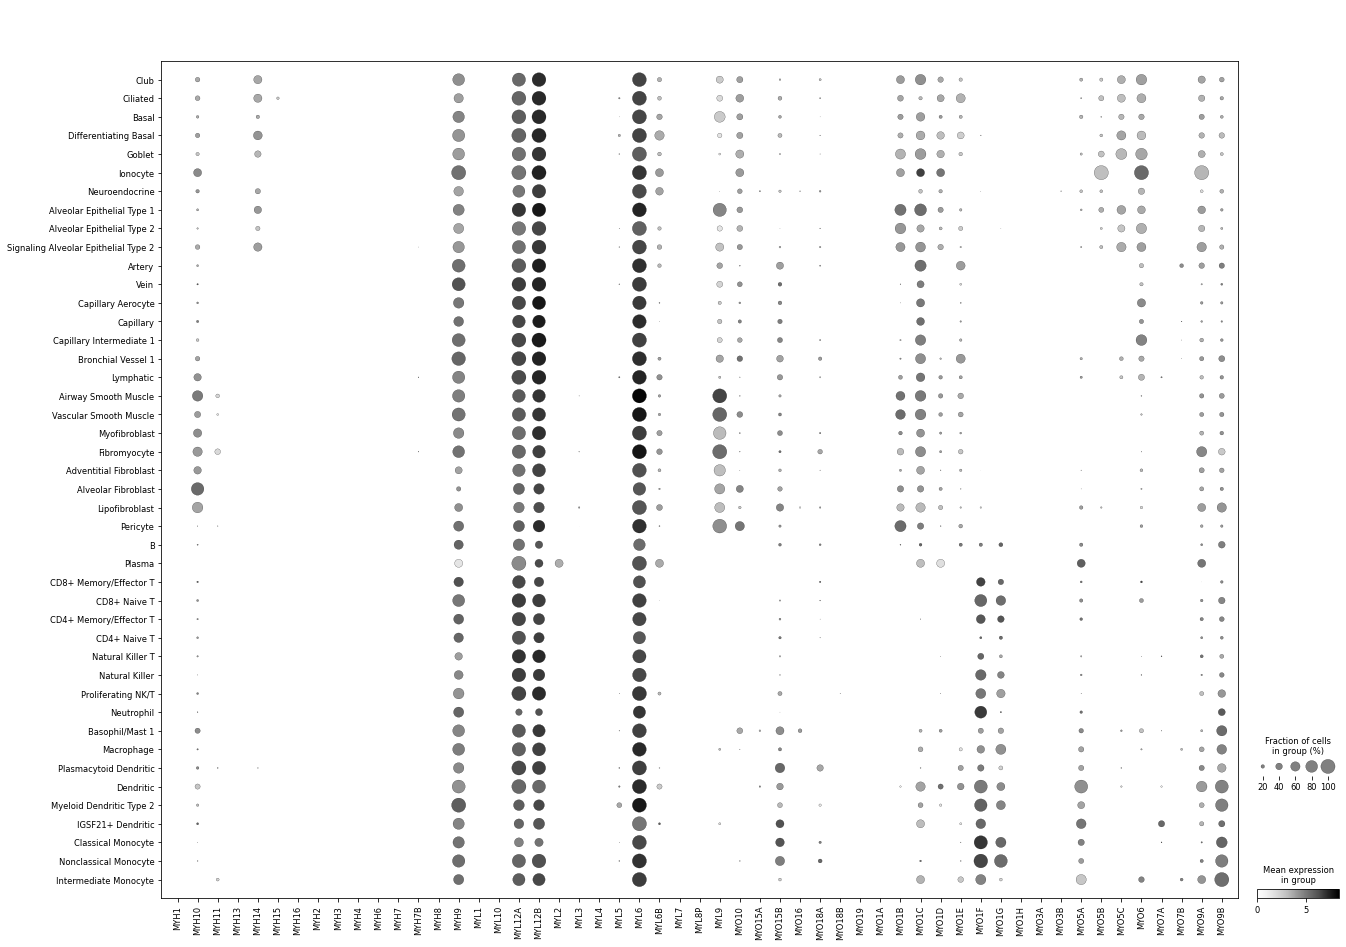

In [33]:
# This is scanpy's dotplot function, for more usage information see:
# https://scanpy.readthedocs.io/en/stable/api/scanpy.pl.dotplot.html#scanpy.pl.dotplot
# Plot myosin genes
sc.pl.dotplot(adata, var_names = myosin_genes, groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


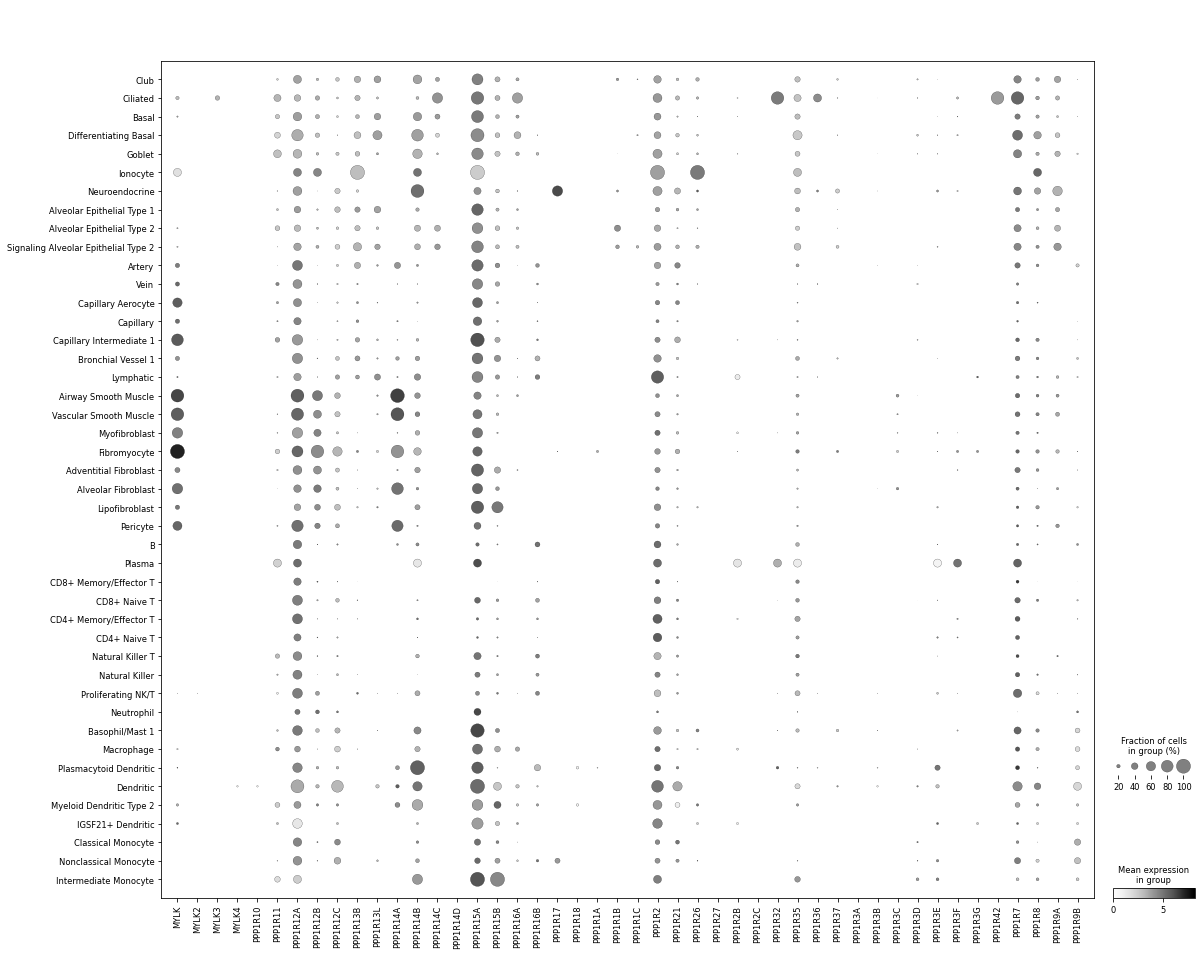

In [34]:
# Plot combined myosin kinase (MYLK) and phosphatase genes (PP1)
sc.pl.dotplot(adata, var_names = myosin_kin_genes.union(myosin_phos_genes), groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


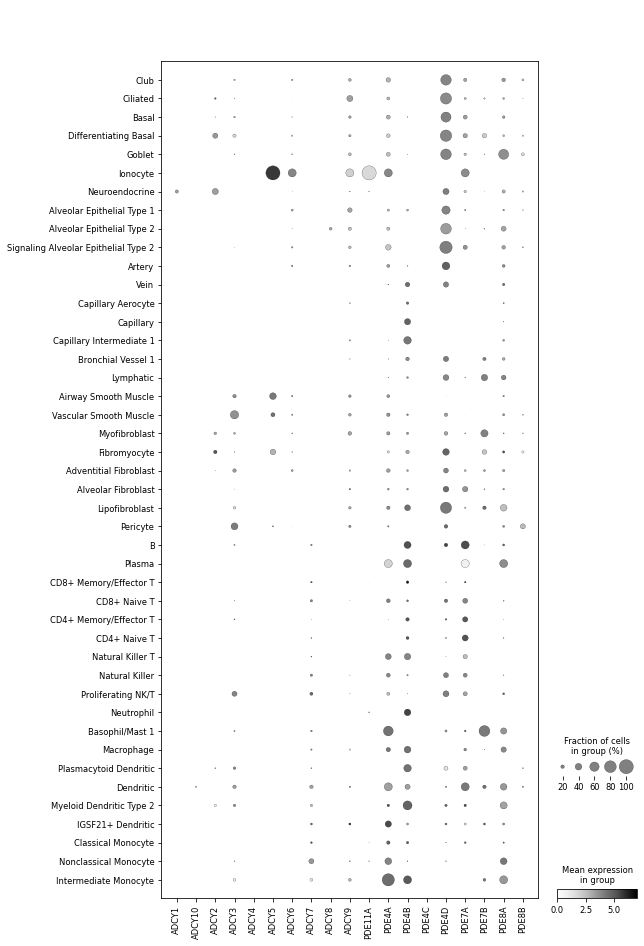

In [35]:
# Plot combined cAMP synthesis (ADCY) and degredation genes (PDE)
sc.pl.dotplot(adata, var_names = cAMP_syn_genes.union(cAMP_deg_genes), groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


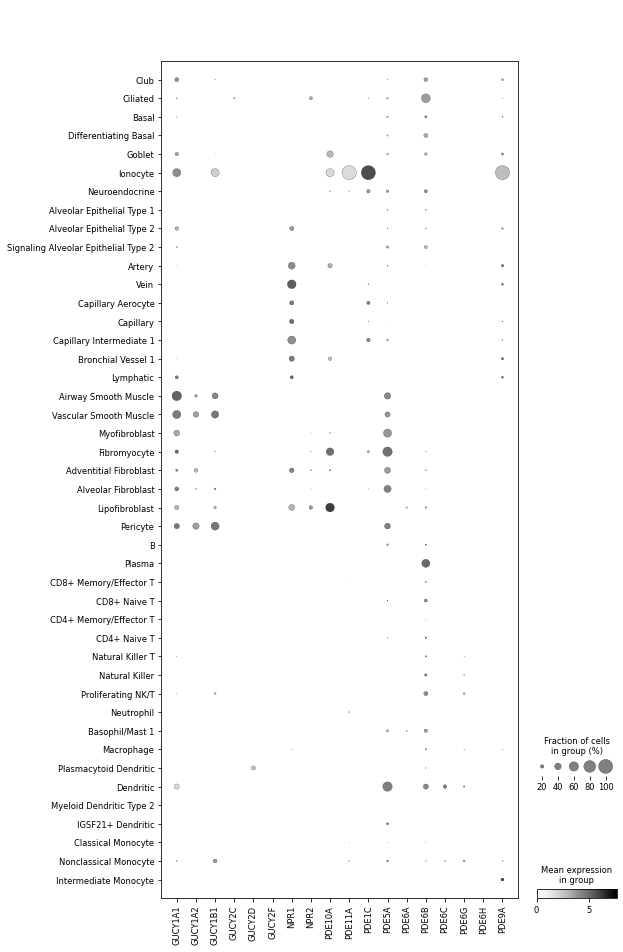

In [36]:
# Plot combined cGMP synthesis (GUCY) and degredation genes (PDE)
sc.pl.dotplot(adata, var_names = cGMP_syn_genes.union(cGMP_deg_genes), groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


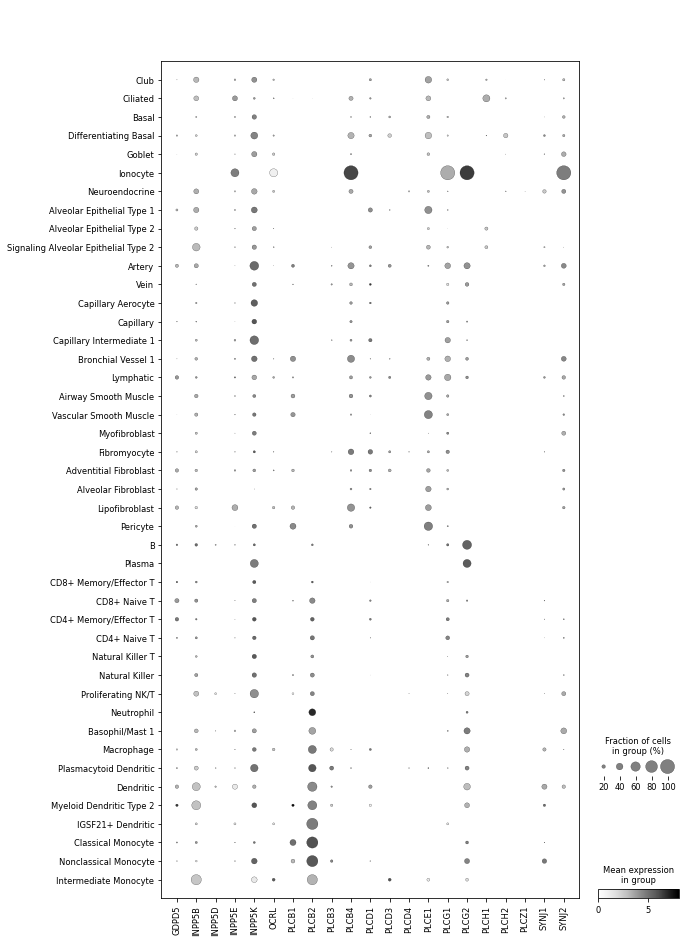

In [84]:
sc.pl.dotplot(adata, var_names = IP3_syn_genes.union(IP3_deg_genes), groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


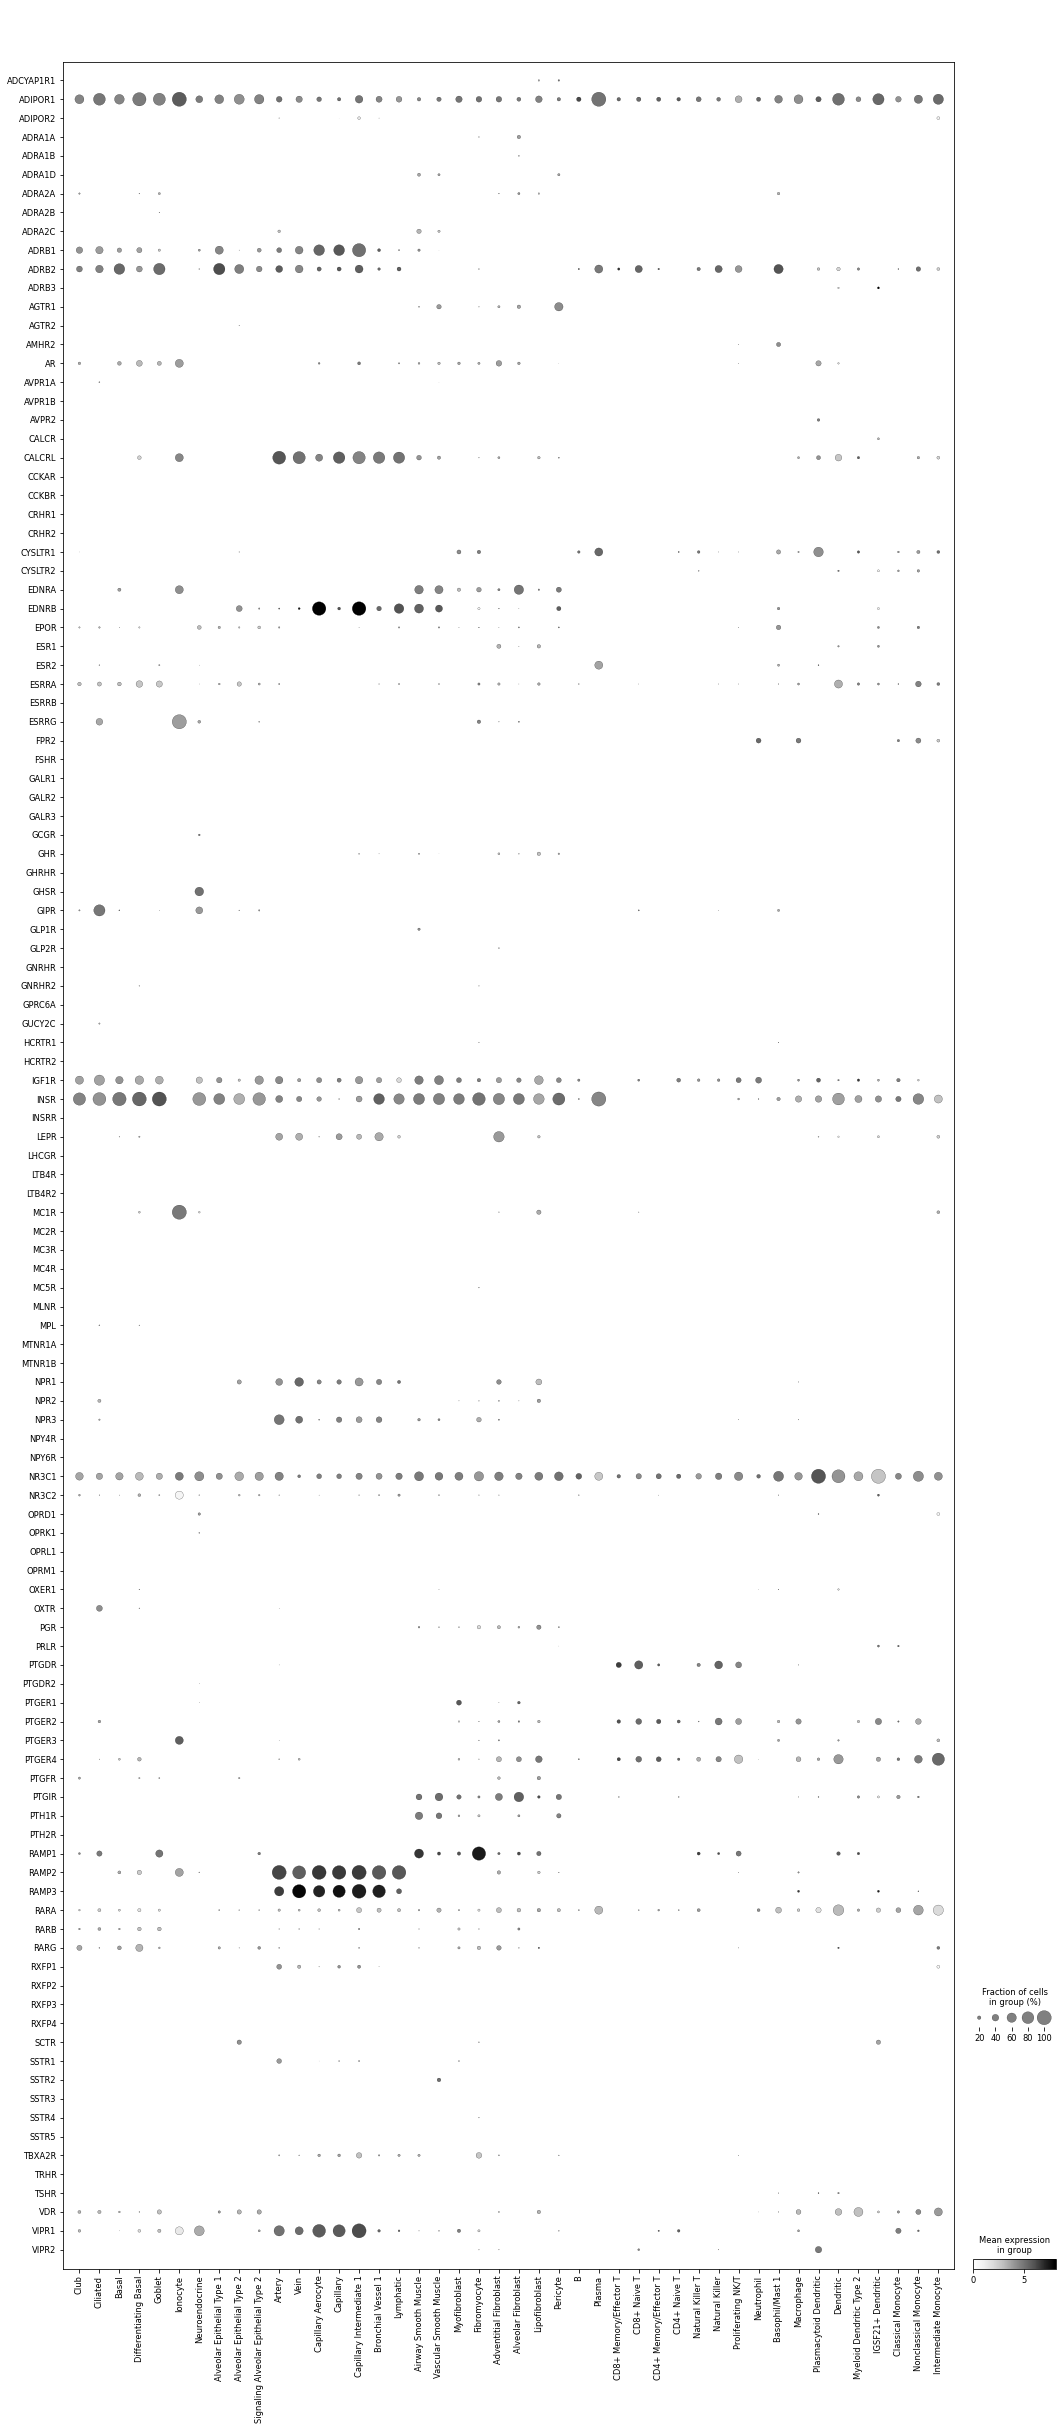

In [82]:
sc.pl.dotplot(adata, var_names = np.intersect1d(hormones.index.to_list(),adata.var_names), groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05, swap_axes=True)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


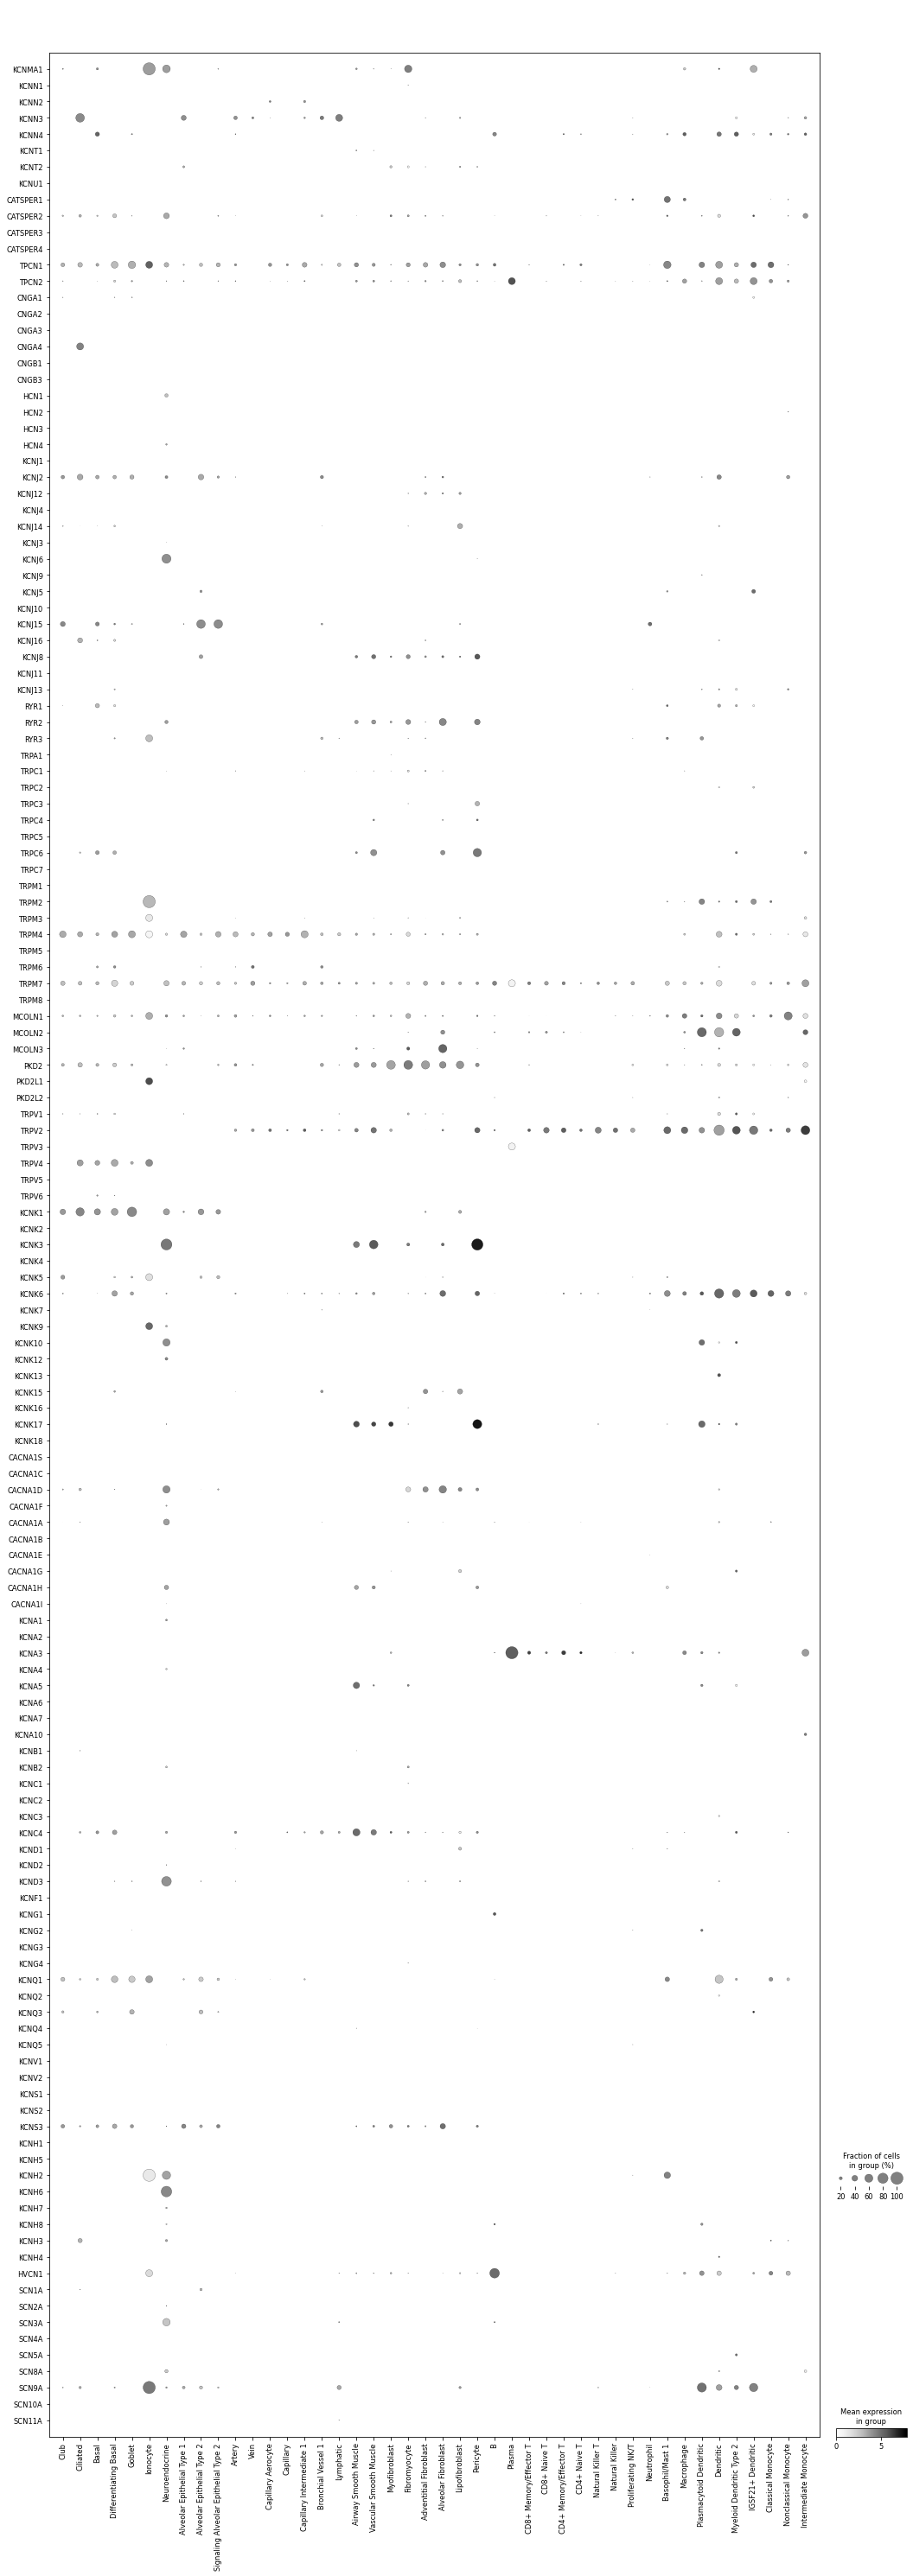

In [85]:
sc.pl.dotplot(adata, var_names = vgic_genes, groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05, swap_axes=True)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


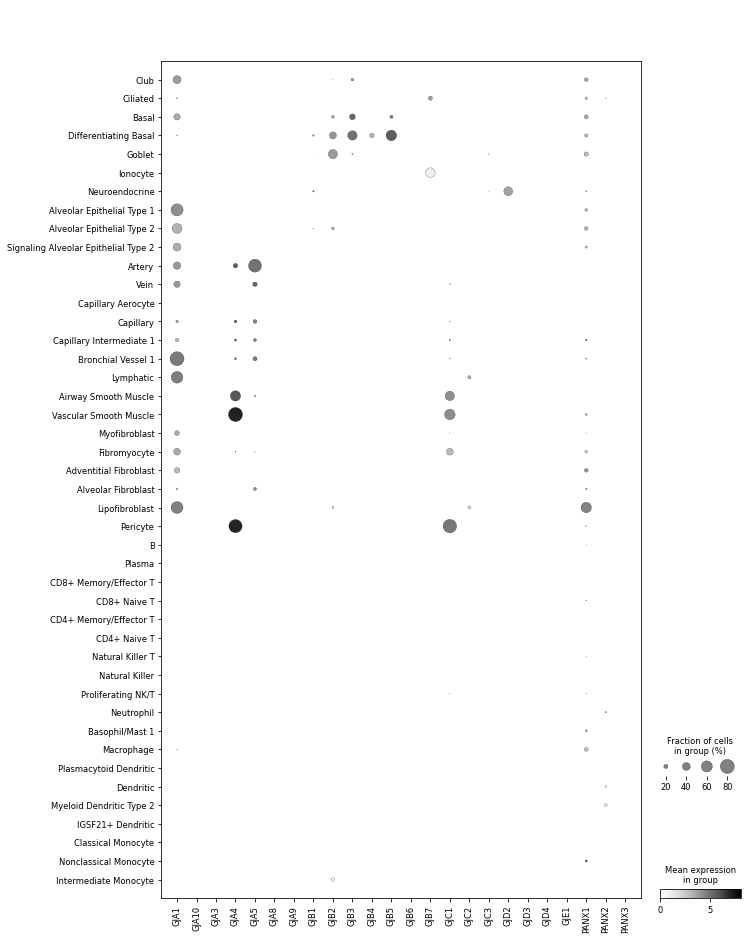

In [80]:
sc.pl.dotplot(adata, var_names = gap_genes, groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05)

**Question:** Does the expression of the various components of contractility support the hypothesis? Did we learn about specific myosins, second messenger enzymes, hormone receptors, ion channels, and gap junctions pericytes use? Are they the same used with Vascular Smooth Muscle?

**Answer:**

### Example 2

Many viruses enter our bodies through inhalation, after which they travel down the respiratory tract and then attach to and enter cells to start productive infections. The topic has come to the fore with the global pandemic, with many groups looking at single cell RNA sequencing datasets to identify where the putative SARS-CoV-2 receptor _ACE2_ and accessory protease _TMPRSS2_ are expressed. These genes can be plotted on Violin plots with the code block below

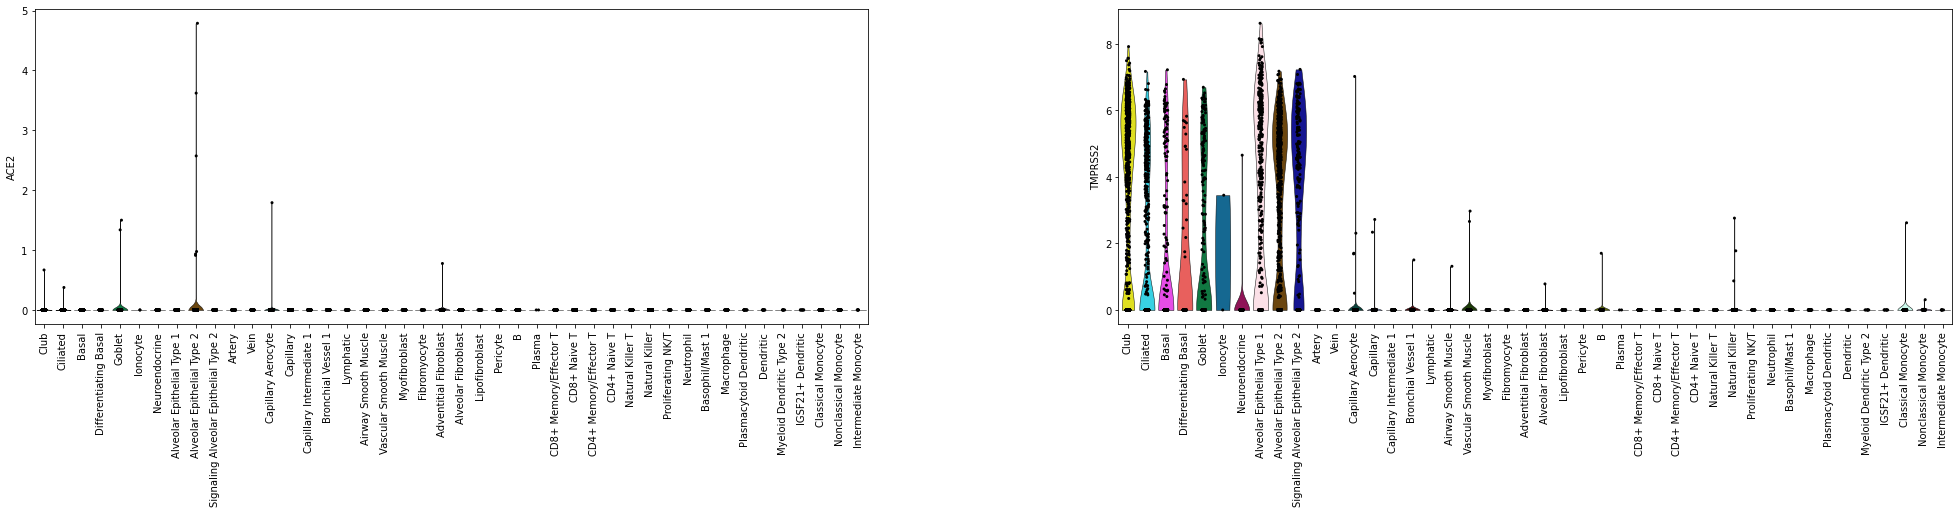

In [89]:
plt.rcParams['figure.figsize'] = [12, 6]

# We can use violin plots to show the distribution of expression across cell types 
sc.pl.violin(adata, keys=['ACE2', 'TMPRSS2'], groupby="free_annotation", rotation=90, size=3, linewidth=0.5)

**Question**: Many groups have implicated Alveolar Epithelial Type 2 cells as a susceptible cell type, does the expression of _ACE2_ and _TMPRSS2_ support this? Do the data suggest other cell types are vulnerable?

**Answer:**

In addition to zeroing in on a specific virus, we could take a wider view and ask: What does expression of all protein receptors associated with viral entry for humans look like?

To do this, we leverage Gene Ontology terms, not for enrichment analysis, but as a starting place for a gene list. After restricting entries associated with the term "viral entry into host cell"(http://amigo.geneontology.org/amigo/term/GO:0046718) to human genes, without "NOT" qualifiers, and with UniProt as their source, we are left with roughly 100 putative receptors. We then search the contributing database (UniProt) for each gene product and identify the paper(s) that support the gene ontology annotation. From these, we filter out genes with weak evidence and identify the specific virus each receptor facilitates entry for (in some cases more than one). After assembling the list of all viruses with protein receptors (this does not include viruses that use non-protein receptors like sialic acid), we then cultivate metadata on each virus including its family, genus, genome type, size, pathology, and whether the lung is its primary entry site (another common one being oral-fecal).

Below, we are reading in two CSVs created by the process described above.

In [41]:
viral_entry = pd.read_csv(os.path.join(pwd, 'dbs', 'viral_entry.csv'), index_col=0)
virus_metadata = pd.read_csv(os.path.join(pwd, 'dbs', 'virus_metadata.csv'), index_col=0)
display(viral_entry)
display(virus_metadata)

,PMID,Virus 1,Virus 2,Virus 3,Virus 4,Virus 5,Virus 6,Virus 7,Virus 8,Virus 9,Virus 10,Virus 11,Virus 12,Virus 13,Virus 14,Virus 15,Virus 16
Gene,,,,,,,,,,,,,,,,,
LAMP1,24970085,Lassa virus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITGAV,24367260|18045938|20615244|7519807|11160695|23...,Herpes simplex 1,Human herpesvirus 8,Adenovirus type C,Coxsackievirus A9,Human parechovirus 1,West nile virus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UVRAG,24550300|24550300,Influenza A virus,Vesicular stomatitis virus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WWP2,20333243,Adenovirus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NPC1,25855742,Ebolavirus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAV2,8030260,Enterovirus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITGA5,12907437|24478423,Human metapneumovirus,Human parvovirus B19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAV1,23760234,Enterovirus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FamilyID,Family,Genus,Pathology,Genome,Size (nm),Lung entry
Virus,,,,,,,
Adenovirus,1,Adenoviridae,NaN,Mild respitory infection,dsDNA,100,True
Adenovirus subgroup Ad3,1,Adenoviridae,NaN,Mild respitory infection,dsDNA,100,True
Adenovirus subgroup B,1,Adenoviridae,NaN,Mild respitory infection,dsDNA,100,True
Adenovirus subgroup B2,1,Adenoviridae,NaN,Mild respitory infection,dsDNA,100,True
Adenovirus type C,1,Adenoviridae,NaN,Mild respitory infection,dsDNA,100,True
...,...,...,...,...,...,...,...
Rabies virus,20,Rhabdoviridae,NaN,Rabies,ssRNA,180,NaN
Vesicular stomatitis virus,20,Rhabdoviridae,NaN,Mild respitory infection,ssRNA,200,True
Ross river virus,21,Togaviridae,NaN,Joint pain,ssRNA,70,NaN


In [42]:
# Rules for cleaning up and shorten the viral names for display purposes
vir_reg = {" ?virus": "",
           " ?human ?": "",
           " ?subgroup": "", 
           " ?type": "",
           " +$": "",
           "simplex ?": "",
           "Immunodeficiency": "HIV",
           "Mammalian": "Mam",
           "Hepatitis": "Hep",
           "Japanese": "Jp",
           "Venezuelan": "Vz",
           "Adeno-associated": "AAV",
           "Respiratory syncytial": "RSV",
           "Rift valley fever": "RVF",
           "Influenza": "Flu"}

# In python we can create custom functions that perform tasks on inputs
# and then return the outputs. The functions we have been using from pandas
# scanpy, velocyto, and more are all custom functions created by users
#
# You can define functions with "def" like so:
# def function_name(input_varable1, input_variable2, ...):
#    return task to perform with input_varable1 and input_variable2
#
# One example:
# def add_a_comma(word1, word2):
#    return ",".join(word1, word2)
#
# where add_a_comma('Travaglini', 'Kyle') would return 'Travaglini,Kyle'
#
# Function to loop through virus and apply virus renaming rules using the
# sub() function from the re library. re.I is a special flag that tells
# sub() to ignore case when searching for words to replace.
def replace_all(dict, text):
    for i, j in dict.items():
        text = re.sub(i, j, text, flags=re.I)
    return text

In [43]:
# Seperate the viruses whose primary route of infection is through the lung
# versus through other avenues into different lists
lung_viruses = virus_metadata[virus_metadata['Lung entry'] == True].index.tolist()
other_viruses = virus_metadata[virus_metadata['Lung entry'] != True].index.tolist()

# Create empty lists to hold genes and viruses that enter through the lungs
lung_entry_genes = []
lung_entry_viruses = []

# Create empty lists to hold genes and viruses that enter other ways
other_entry_genes = []
other_entry_viruses  = []

# Loop through each viral receptor
for i in viral_entry.index:
    
    # Subset the viral_entry table to the current viral receptor
    tmp = viral_entry[viral_entry.index == i]
    
    # Use nested list comprehension to identify **respiratory** viruses the current receptor facilitates entry for,
    # clean the name up with replace_all, and raise the first letter in each name to uppercase
    virus_tmp = [k[:1].upper() + k[1:] for k in [replace_all(vir_reg, j) for j in tmp.loc[i,:][[x in lung_viruses for x in tmp.iloc[0,:]]].tolist()]]
    
    # Sort the cleaned **respiratory** virus names alphabetically
    virus_tmp.sort()
    
    # If the current receptor facilities entry for repsiratory virus(es),
    # add it and the viruses to the lung list
    if len(virus_tmp) > 0:
        lung_entry_genes.append(i)
        lung_entry_viruses.append("   ".join(virus_tmp))

    # Use nested list comprehension to identify **non-respiratory** viruses the current receptor facilitates entry for,
    # clean the name up with replace_all, and raise the first letter in each name to uppercase    
    virus_tmp = [k[:1].upper() + k[1:] for k in [replace_all(vir_reg, j) for j in tmp.loc[i,:][[x in other_viruses for x in tmp.iloc[0,:]]].tolist()]]
    
    # Sort the cleaned **non-respiratory** virus names alphabetically
    virus_tmp.sort()
    
    # If the current receptor facilities entry for **non-repsiratory** virus(es),
    # add it and the viruses to the other list
    if len(virus_tmp) > 0:
        other_entry_genes.append(i)
        other_entry_viruses.append("   ".join(virus_tmp))

# Create dataframes for the respiratory and non-respiratory viral entry receptors and
# sort them based on the cleaned virus names
lung_entry = pd.DataFrame(data={'viruses': lung_entry_viruses}, index=lung_entry_genes)
lung_entry.sort_values(by="viruses", axis=0, inplace=True)
other_entry = pd.DataFrame(data={'viruses': other_entry_viruses}, index=other_entry_genes)
other_entry.sort_values(by="viruses", axis=0, inplace=True)

In [44]:
# Print the receptors and viruses for respiratory viruses
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(lung_entry)

                                           viruses
RPSA                 AAV 2   AAV 3   AAV 8   AAV 9
WWP2                                         Adeno
CD46                Adeno Ad3   Adeno B2   Measles
CD86                                       Adeno B
CD80                                       Adeno B
CXADR                                      Adeno C
ITGB5                                      Adeno C
ITGAV                          Adeno C   Parecho 1
ANPEP                                  Corona 229E
CLEC4M                           Corona 229E   Flu
DPP4                                   Corona MERS
ACE2     Corona NL63   Corona SARS   Corona SARS-2
CLEC4G                                 Corona SARS
CD209    Corona SARS   Flu A   Measles   RSV   RVF
GYPA                                           Flu
UVRAG                 Flu A   Vesicular stomatitis
ITGB3             Hantaan   Metapneumo   Parecho 1
F11R                                       Mam reo
ITGB1                          

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


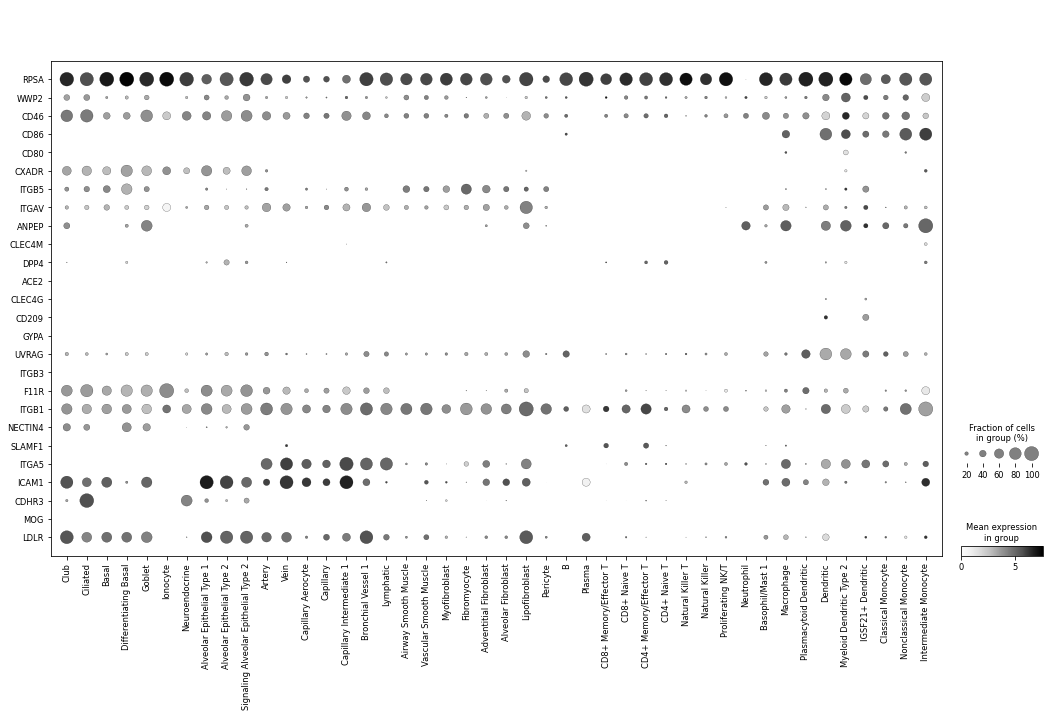

In [70]:
plt.rcParams['figure.figsize'] = [12, 6]

# Plot the receptors for respiratory viruses
sc.pl.dotplot(adata, var_names = lung_entry.index, groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05, swap_axes=True)

In [48]:
# Print the receptors and viruses for non-respiratory viruses
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(other_entry)

                                                    viruses
ICAM1                                         Coxsackie A21
CD55      Coxsackie A21   Coxsackiees B1   Coxsackiees B...
ITGB3      Coxsackie A9   Cytomegalo   Herpes 8   West nile
ITGB6                               Coxsackie A9   Herpes 1
ITGAV        Coxsackie A9   Herpes 1   Herpes 8   West nile
CXADR     Coxsackie B1   Coxsackie B2   Coxsackie B3   C...
ANPEP                                            Cytomegalo
CD209     Cytomegalo   Dengue   Ebola   HIV 1   HIV 2   ...
ITCH      Cytomegalo   Ebola   Epstein-Barr   Herpes 1  ...
CLEC4M    Cytomegalo   Ebola   HIV 1   Hep C   Jp enceph...
ITGB1     Cytomegalo   Echo 1   Echo 8   Epstein-Barr   ...
HAVCR1                     Dengue   Ebola   Hep A   Marburg
GAS6                    Dengue   Ebola   Marburg   Vaccinia
MRC1                                         Dengue   Hep B
CLDN1                                        Dengue   Hep C
GRK2                          Dengue   H

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


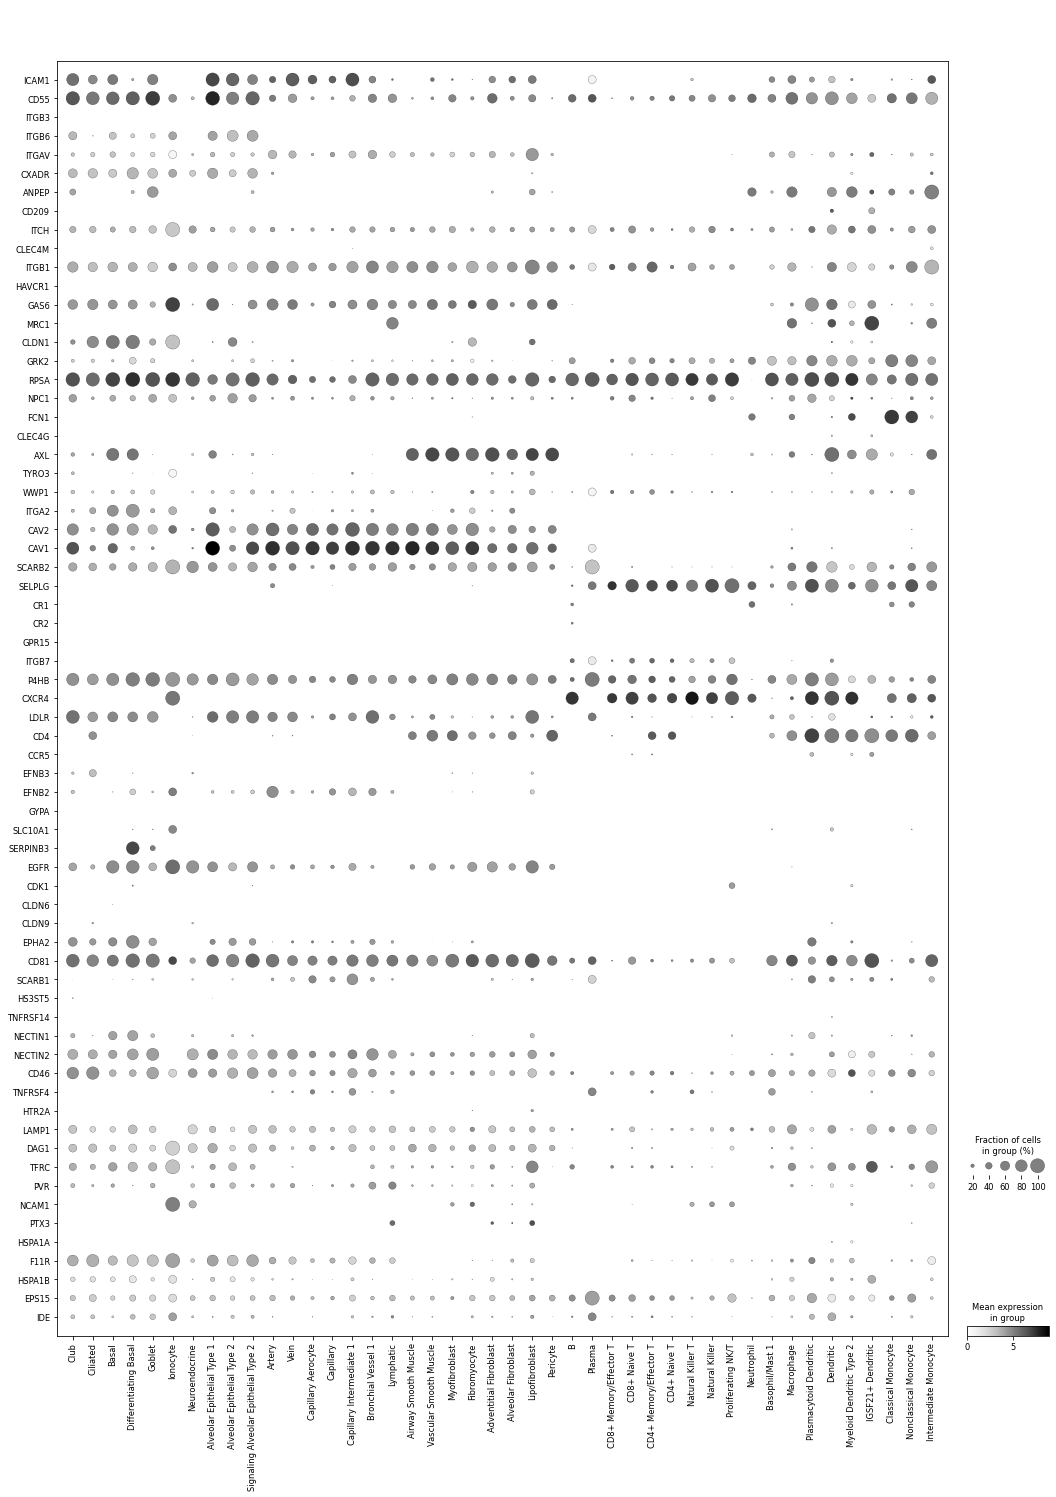

In [76]:
plt.rcParams['figure.figsize'] = [12, 14]

# Plot the receptors for non-respiratory viruses
sc.pl.dotplot(adata, var_names = other_entry.index, groupby="free_annotation", mean_only_expressed=True, cmap="Greys", dot_min=0.05, swap_axes=True)

**Questions:** Do you notice any interesting expression patterns for respiratory and non-respiratory viruses? Why might we have included the non-respiratory viruses here?

**Answer:**

### Example 3

This one is up to you! The HLCA SmartSeq2 dataset contains cell types across all the major tissue compartments for the lung. Come a question, either directed like Example 1 or more open like Example 2, then practice making a gene list to address it. After, visualize the genes using whatever plotting functions you feel are best.

**Question:** What was your question? What was the answer?

**Answer:**